# 29.02.20

**Author:** Miron Rogovets

---

### Task 1. Regression analysis

Do the multiple regression analysis using the following variables from **data_games.dta**: 

Dependent variable: <code>payment</code>

Independent variables: <code>payment_type, payment_method, crystalls_balance_before_buy, crystalls_bought</code> 

Describe the model:
1. Specify the regression equation. 
2. Assess the goodness-of-fit of the model (R-square, significance of the model);
3. Which independent variables significantly influence the dependent variable (explain your answer)? 
4. Describe the relationship between each independent and the dependent variable.

Do the diagnostics of the model: 
5. Are the residuals normally distributed? 
6. Are there any outliers (standardized residuals greater than 3, or less that -3)?
7. Test the multicollinearity and heteroscedasticity.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
from scipy.stats import zscore, norm
import statsmodels.formula.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.outliers_influence import OLSInfluence as influence

In [3]:
df = pd.read_stata('data/data_games.dta')
df.head()

,id,pack_id,crystalls_balance_before_buy,crystalls_bought,country,payment,utc_timestamp,payment_type,payment_method
0,2.052791e+09,3.0,0.0,41.0,GB,644.0,1.414842e+09,offer,general
1,1.275033e+09,1.0,10.0,7.0,US,205.0,1.414814e+09,offer,general
2,2.000015e+14,2.0,2.0,14.0,US,514.0,1.414866e+09,regular,general
3,1.119068e+09,4.0,0.0,70.0,GB,1289.0,1.414917e+09,regular,general
4,2.000028e+14,3.0,0.0,30.0,US,1029.0,1.414946e+09,regular,general


In [4]:
data = df[['payment', 'payment_type', 'payment_method', 'crystalls_balance_before_buy', 'crystalls_bought']]
data.head()

,payment,payment_type,payment_method,crystalls_balance_before_buy,crystalls_bought
0,644.0,offer,general,0.0,41.0
1,205.0,offer,general,10.0,7.0
2,514.0,regular,general,2.0,14.0
3,1289.0,regular,general,0.0,70.0
4,1029.0,regular,general,0.0,30.0


In [5]:
print(data.payment_method.unique())
data.payment_type.unique()

[general, mobile, fb_promotion, giftcard]
Categories (4, object): [fb_promotion < general < giftcard < mobile]


[offer, regular]
Categories (2, object): [offer < regular]

In [6]:
data.payment_method.value_counts()

general         103278
mobile            1673
fb_promotion       498
giftcard            58
Name: payment_method, dtype: int64

Check if we have any missing values

In [7]:
data.isna().sum()

payment                         0
payment_type                    0
payment_method                  0
crystalls_balance_before_buy    0
crystalls_bought                0
dtype: int64

Since our data has two catogorical features, we should convert them to numeric. Although we can use simple Label encoding, we should avoid it as our model may think that a column has data with some kind of order or hierarchy, when it doesn't

In [8]:
data_encoded = pd.get_dummies(data, prefix=['payment_type', 'payment_method'], 
                              columns = ['payment_type', 'payment_method'])
data_encoded.head()

,payment,crystalls_balance_before_buy,crystalls_bought,payment_type_offer,payment_type_regular,payment_method_fb_promotion,payment_method_general,payment_method_giftcard,payment_method_mobile
0,644.0,0.0,41.0,1,0,0,1,0,0
1,205.0,10.0,7.0,1,0,0,1,0,0
2,514.0,2.0,14.0,0,1,0,1,0,0
3,1289.0,0.0,70.0,0,1,0,1,0,0
4,1029.0,0.0,30.0,0,1,0,1,0,0


We use <code>payment_type_offer</code> as reference variable for dummy encoded _payment_type_ and <code>payment_method_general</code> for _payment_method,_ so we do not include them in our features list

In [9]:
df = data_encoded.drop(columns=['payment_type_offer', 'payment_method_general']).copy()
df.head()

,payment,crystalls_balance_before_buy,crystalls_bought,payment_type_regular,payment_method_fb_promotion,payment_method_giftcard,payment_method_mobile
0,644.0,0.0,41.0,0,0,0,0
1,205.0,10.0,7.0,0,0,0,0
2,514.0,2.0,14.0,1,0,0,0
3,1289.0,0.0,70.0,1,0,0,0
4,1029.0,0.0,30.0,1,0,0,0


Create and fit our model

In [10]:
formula_str = df.columns[0] + ' ~ ' + '+'.join(df.columns[1:])
formula_str

'payment ~ crystalls_balance_before_buy+crystalls_bought+payment_type_regular+payment_method_fb_promotion+payment_method_giftcard+payment_method_mobile'

In [11]:
model = sm.ols(formula=formula_str, data=df)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                payment   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                 4.985e+04
Date:                Wed, 04 Mar 2020   Prob (F-statistic):               0.00
Time:                        18:49:57   Log-Likelihood:            -8.4391e+05
No. Observations:              105507   AIC:                         1.688e+06
Df Residuals:                  105500   BIC:                         1.688e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

### Model description

In [12]:
coefs = pd.DataFrame()
coefs['Coefs'] = fitted.params[1:]
coefs['Features'] = fitted.params.index[1:]
coefs.set_index('Features', inplace=True)
print('Intercept = ', fitted.params[0])
coefs

Intercept =  42.9762640074718


,Coefs
Features,
crystalls_balance_before_buy,-0.606720
crystalls_bought,16.174186
payment_type_regular,395.624772
payment_method_fb_promotion,-256.356112
payment_method_giftcard,-2176.716994
payment_method_mobile,-598.934531


We have the following regression equation:

In [13]:
ss = []
for (param, index) in zip(fitted.params[1:], fitted.params.index[1:]):
    ss.append('{:.3f}*{}'.format(param, index))
    
print('Y = {:3f} + {}'.format(fitted.params[0], ' + '.join(ss)))

Y = 42.976264 + -0.607*crystalls_balance_before_buy + 16.174*crystalls_bought + 395.625*payment_type_regular + -256.356*payment_method_fb_promotion + -2176.717*payment_method_giftcard + -598.935*payment_method_mobile


$R^2$ & model significance:

In [14]:
print('R^2 = {:f}'.format(fitted.rsquared))
print('F stat = {:f}'.format(fitted.f_pvalue))

R^2 = 0.739257
F stat = 0.000000


The regression model is statistically significant. It explains 73.9% of payment’s variation

In [15]:
def yes_no(b):
    if abs(b) < 0.05:
        return 'Yes'
    else:
        return 'No'

In [16]:
pvals = pd.DataFrame()
pvals['p_values'] = fitted.pvalues[1:]
pvals['Statistically significant?']= pvals['p_values'].apply(yes_no)
pvals['p_values'] = pvals['p_values'].map('{:.3f}'.format)
pvals['Features'] = df.columns[1:]
pvals.set_index('Features',inplace=True)

In [17]:
pvals

,p_values,Statistically significant?
Features,,
crystalls_balance_before_buy,0.000,Yes
crystalls_bought,0.000,Yes
payment_type_regular,0.000,Yes
payment_method_fb_promotion,0.000,Yes
payment_method_giftcard,0.000,Yes
payment_method_mobile,0.000,Yes


All variables are statistically significant, which means that all of them contribute in dependent variable _payment_

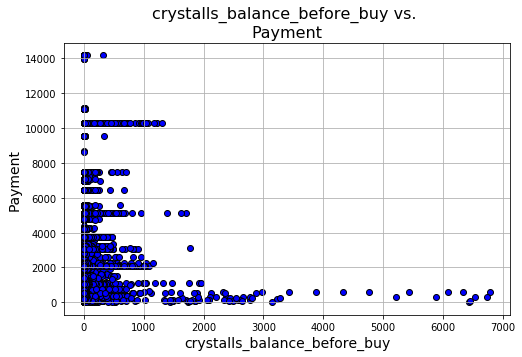

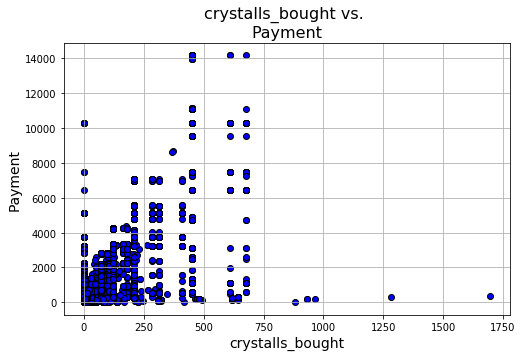

In [18]:
for c in df.columns[1:3]:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nPayment".format(c),fontsize=16)
    plt.scatter(x=df[c],y=df.payment,color='blue',edgecolor='k')
    plt.grid(True)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Payment',fontsize=14)
    plt.show()

**Features relationship:**

1. Increase of current balance by 1 crystall decreases the future payment by 0.6
2. Every bought crystall increases the payment by 16.2
3. The payment via regular type is significantly higher than the payment via offers. The average difference is 395.6
4. The general payment method is significantly higher than all other payment methods.

---

### Model diagnostics

To test whether the residuals are normally distributed we define following hypothesis and apply Kolmogorov-Smirnov test:

- H0: the distribution of residuals **is not** significantly different form the normal distribution
- H1: the distribution of residuals **is** significantly different form the normal distribution

In [19]:
p = kstest(fitted.resid, 'norm').pvalue
print('P-value: ', p)
if p <= 0.05:
    print('Reject H0')
else:
    print('Accept H0')

P-value:  0.0
Reject H0


We can also use _Jarque–Bera test_ to test of whether sample data have the _skewness_ $(S)$ and _kurtosis_ $(K)$ matching a normal distribution 

H0: $(S=0, K=3)$

In [20]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(fitted.resid)
for z in zip(name, test):
    print(z)
    
if test[2] == 0.0 and test[3] == 3:
    print('Accept H0')
else:
    print('Reject H0')

('Jarque-Bera', 22721624.066504825)
('Chi^2 two-tail prob.', 0.0)
('Skew', -4.0391901406015425)
('Kurtosis', 74.43736484609465)
Reject H0


_The distribution of residuals is different from normal distribution._

#### Check if we have outliers:

In [21]:
infl = influence(fitted)

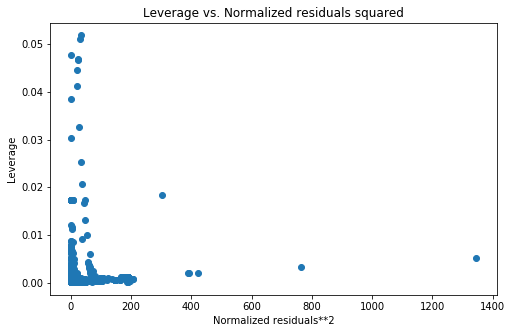

In [22]:
plt.figure(figsize=(8,5))
leverage = infl.hat_matrix_diag
resid = zscore(infl.resid)
plt.plot(resid**2, leverage, 'o')
plt.xlabel("Normalized residuals**2")
plt.ylabel("Leverage")
plt.title("Leverage vs. Normalized residuals squared")
plt.show()

In [23]:
(abs(fitted.resid_pearson) > 3.0).sum()

1778

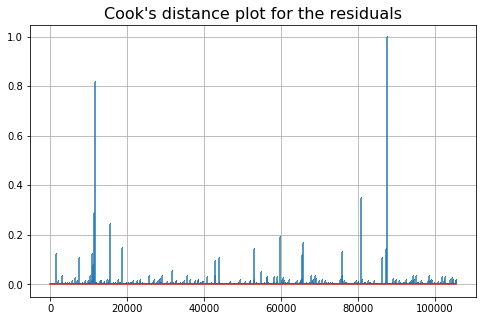

In [24]:
c, p = infl.cooks_distance
plt.figure(figsize=(8,5))
plt.title("Cook's distance plot for the residuals", fontsize=16)
plt.stem(np.arange(len(c)), c, markerfmt=",", use_line_collection=True)
plt.grid(True)
plt.show()

_There are data points with residuals being possible outliers_

#### Multicollinearity & Heteroscedasticity tests

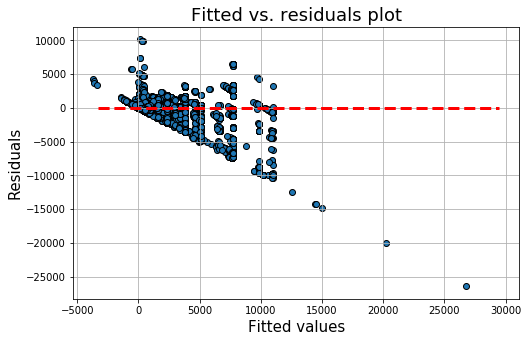

In [25]:
plt.figure(figsize=(8,5))
p = plt.scatter(x=fitted.fittedvalues,y=fitted.resid,edgecolor='k')
xmin = min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
plt.hlines(y=0, xmin=xmin * 0.9, xmax=xmax*1.1, color='red', linestyle='--', lw=3)
plt.xlabel("Fitted values", fontsize=15)
plt.ylabel("Residuals", fontsize=15)
plt.title("Fitted vs. residuals plot", fontsize=18)
plt.grid(True)
plt.show()

In [26]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(fitted.resid, fitted.model.exog)

for z in zip(name, test):
    print(z)

('Lagrange multiplier statistic', 21976.24738559481)
('p-value', 0.0)
('f-value', 4626.028990550121)
('f p-value', 0.0)


We can see a heteroscedasticity from the plot above – there is a relationship between residuals and the fitted values. This is also proved by Breusch-Pagan Lagrange Multiplier test.

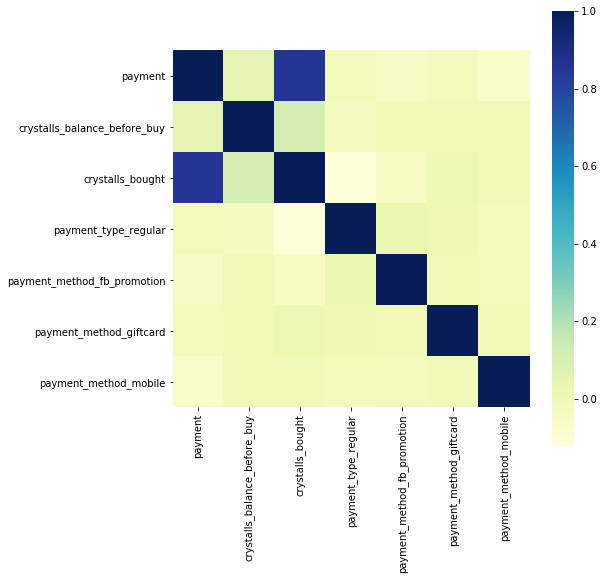

In [27]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), square = True, cmap='YlGnBu')
plt.show()

In [28]:
vifs = [vif(fitted.model.exog, i) for i in range(fitted.model.exog.shape[1])]
vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = df.columns[1:]
vif_df

,VIF,Features
0,1.013560,crystalls_balance_before_buy
1,1.029407,crystalls_bought
2,1.016298,payment_type_regular
3,1.002130,payment_method_fb_promotion
4,1.000447,payment_method_giftcard
5,1.000555,payment_method_mobile


_We do not have variables with high correlation and there are no VIFs greater than 10, so we can say that there is no multicollinearity_